# 彼得与狼：强化学习入门

在本教程中，我们将学习如何将强化学习应用于路径寻找问题。这个场景灵感来源于俄罗斯作曲家[谢尔盖·普罗科菲耶夫](https://en.wikipedia.org/wiki/Sergei_Prokofiev)创作的音乐童话故事[《彼得与狼》](https://en.wikipedia.org/wiki/Peter_and_the_Wolf)。故事讲述了年轻的先锋彼得勇敢地走出家门，来到森林空地追逐狼的冒险经历。我们将训练机器学习算法，帮助彼得探索周围区域并构建一张最优导航地图。

首先，让我们导入一些有用的库：


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## 强化学习概述

**强化学习**（RL）是一种学习技术，通过运行大量实验，让我们能够学习到某个**环境**中**智能体**的最优行为。在这个环境中，智能体应该有一个明确的**目标**，由一个**奖励函数**来定义。

## 环境

为了简单起见，我们将彼得的世界设定为一个大小为 `width` x `height` 的方形棋盘。在这个棋盘上的每个格子可以是：
* **地面**，彼得和其他生物可以在上面行走
* **水域**，显然无法在上面行走
* **树**或**草地**——一个可以休息的地方
* **苹果**，代表彼得很乐意找到的食物以填饱肚子
* **狼**，危险的存在，应该尽量避开

为了与环境交互，我们将定义一个名为 `Board` 的类。为了避免让这个笔记本过于复杂，我们已将所有与棋盘相关的代码移至一个单独的 `rlboard` 模块中，现在我们将导入该模块。你可以查看这个模块内部的实现细节以了解更多信息。


In [2]:
from rlboard import *

现在让我们创建一个随机棋盘，看看它的样子：


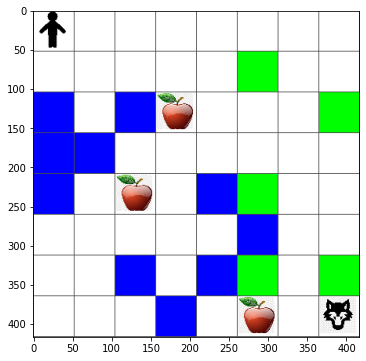

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## 行动与策略

在我们的例子中，彼得的目标是找到一个苹果，同时避开狼和其他障碍物。为此，他可以四处走动直到找到苹果。因此，在任何位置，他可以选择以下行动之一：向上、向下、向左或向右。我们将这些行动定义为一个字典，并将它们映射到对应的坐标变化对。例如，向右移动 (`R`) 对应坐标变化对 `(1,0)`。


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

我们代理（Peter）的策略由一个所谓的**策略**定义。让我们来看看最简单的策略，称为**随机游走**。

## 随机游走

首先，让我们通过实现随机游走策略来解决我们的问题。


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

让我们多次运行随机游走实验，看看平均步数：


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## 奖励函数

为了让我们的策略更加智能，我们需要了解哪些动作比其他动作“更好”。


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

构建一个 Q-Table，或者说是一个多维数组。由于我们的棋盘尺寸是 `width` x `height`，我们可以用一个形状为 `width` x `height` x `len(actions)` 的 numpy 数组来表示 Q-Table：


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

将Q表传递给绘图函数，以便在板上可视化该表：


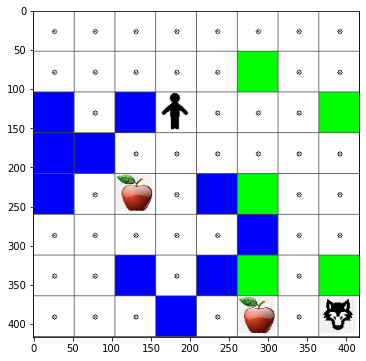

In [9]:
m.plot(Q)

## Q-Learning的核心：贝尔曼方程和学习算法

编写学习算法的伪代码：

* 初始化Q表Q，所有状态和动作的值设为相同
* 设置学习率 $\alpha\leftarrow 1$
* 多次重复模拟
   1. 从随机位置开始
   1. 重复以下步骤
        1. 在状态$s$选择一个动作$a$
        2. 执行动作，移动到新状态$s'$
        3. 如果遇到游戏结束条件，或者总奖励过低——退出模拟  
        4. 计算新状态的奖励$r$
        5. 根据贝尔曼方程更新Q函数：$Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. 更新总奖励并降低$\alpha$。

## 探索与利用

最佳方法是平衡探索与利用。当我们对环境了解得越多时，更倾向于遵循最优路径，但偶尔选择未探索的路径。

## Python实现

现在我们准备实现学习算法。在此之前，我们还需要一些函数，将Q表中的任意数字转换为对应动作的概率向量：


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

我们在原始向量中添加少量的 `eps`，以避免在初始情况下所有向量分量相同时出现除以0的情况。

我们将运行实际的学习算法进行5000次实验，也称为**epochs**：


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

在执行此算法后，Q-表应更新为定义每个步骤中不同动作吸引力的值。在此处可视化该表：


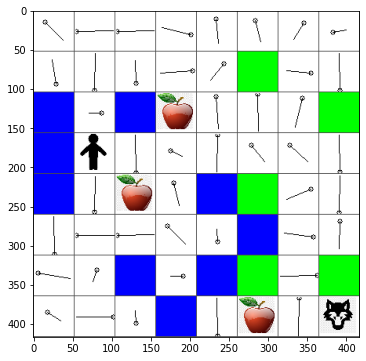

In [12]:
m.plot(Q)

## 检查策略

由于 Q-Table 列出了每个状态下每个动作的“吸引力”，我们可以很容易地利用它来定义在我们的世界中高效的导航。在最简单的情况下，我们只需选择对应最高 Q-Table 值的动作：


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

如果你多次运行上述代码，你可能会注意到有时它会“卡住”，需要按下笔记本中的停止按钮来中断它。

> **任务 1：** 修改 `walk` 函数，限制路径的最大长度为一定步数（例如，100），并观察上述代码是否会不时返回该值。

> **任务 2：** 修改 `walk` 函数，使其不再回到之前已经访问过的地方。这将防止 `walk` 进入循环，但代理仍可能被“困”在一个无法逃脱的位置。


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


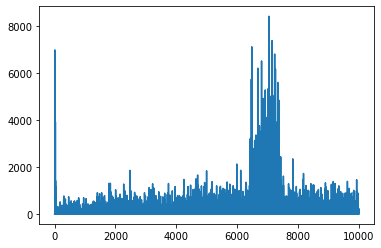

In [15]:
plt.plot(lpath)

我们可以看到，起初平均路径长度有所增加。这可能是因为当我们对环境一无所知时，很容易陷入糟糕的状态，比如掉进水里或遇到狼。随着我们学习更多并开始利用这些知识，我们能够在环境中探索更长时间，但仍然不太清楚苹果的位置。

当我们学到足够多时，代理更容易实现目标，路径长度开始减少。然而，我们仍然会进行探索，因此经常偏离最佳路径，尝试新的选项，这使得路径比最优路径更长。

我们在图表上还观察到，某个时刻路径长度突然增加。这表明过程具有随机性，并且我们可能会在某些时候“破坏”Q-表的系数，通过用新值覆盖它们。这种情况理想情况下应该通过降低学习率来最小化（即在训练后期，我们仅用小幅度调整Q-表的值）。

总体来说，重要的是要记住，学习过程的成功和质量在很大程度上取决于一些参数，比如学习率、学习率衰减和折扣因子。这些通常被称为**超参数**，以区别于我们在训练过程中优化的**参数**（例如Q-表系数）。寻找最佳超参数值的过程被称为**超参数优化**，这是一个值得单独讨论的话题。


## 练习
#### 一个更真实的《彼得与狼》世界

在我们的情境中，彼得几乎可以四处移动而不会感到疲惫或饥饿。在一个更真实的世界里，他需要时不时地坐下来休息，还需要给自己补充食物。让我们通过实现以下规则，使我们的世界更加真实：

1. 每次从一个地方移动到另一个地方，彼得都会损失一定的**能量**并增加一些**疲劳**。
2. 彼得可以通过吃苹果来恢复能量。
3. 彼得可以通过在树下或草地上休息来消除疲劳（即走到有树或草的棋盘位置——绿色区域）。
4. 彼得需要找到并杀死狼。
5. 为了杀死狼，彼得需要达到一定的能量和疲劳水平，否则他会在战斗中失败。

根据游戏规则修改上述奖励函数，运行强化学习算法以学习赢得游戏的最佳策略，并将随机游走的结果与您的算法进行比较，比较胜负场次。

> **注意**: 您可能需要调整超参数以使其正常运行，尤其是训练的轮数。由于游戏的成功（与狼战斗）是一个罕见事件，您可以预期训练时间会更长。



---

**免责声明**：  
本文档使用AI翻译服务 [Co-op Translator](https://github.com/Azure/co-op-translator) 进行翻译。尽管我们努力确保翻译的准确性，但请注意，自动翻译可能包含错误或不准确之处。原始语言的文档应被视为权威来源。对于关键信息，建议使用专业人工翻译。我们不对因使用此翻译而产生的任何误解或误读承担责任。
